In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_Dir = "drive/MyDrive/MachineLearning/Convolutional-Neural-Networks/Melanoma Detection Assignment"
import os
os.chdir(root_Dir)

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: To Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin_cancer_Data/Train")
data_dir_test = pathlib.Path('Skin_cancer_Data/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

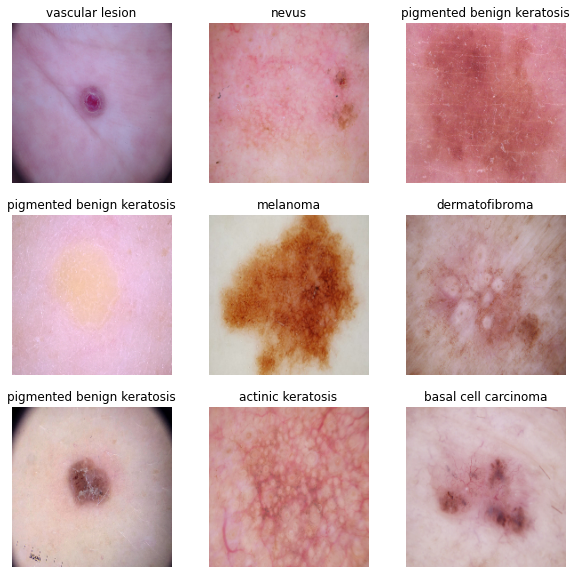

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
### As the pixel values range from 0 to 255,we can scale this to [0,1] by dividing each value by 255
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(len(class_names), activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
### Ref:https://github.com/tensorflow/tensorflow/blob/4f50b5dc6426f63a8e70b65d3b9e55ed8f7d38e2/tensorflow/python/
###      keras/losses.py#L437
### Note: Using from_logits=True may be more numerically stable.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/Users/kcm/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 127s 2s/step - loss: 1.8549 - accuracy: 0.2997 - val_loss: 1.8089 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 148s 3s/step - loss: 1.6871 - accuracy: 0.3733 - val_loss: 1.6053 - val_accuracy: 0.4362
Epoch 3/20
56/56 [==============================] - 155s 3s/step - loss: 1.6292 - accuracy: 0.4096 - val_loss: 1.5661 - val_accuracy: 0.4362
Epoch 4/20
56/56 [==============================] - 158s 3s/step - loss: 1.6222 - accuracy: 0.4129 - val_loss: 1.5822 - val_accuracy: 0.4474
Epoch 5/20
56/56 [==============================] - 159s 3s/step - loss: 1.5422 - accuracy: 0.4420 - val_loss: 1.5600 - val_accuracy: 0.4273
Epoch 6/20
56/56 [==============================] - 160s 3s/step - loss: 1.5593 - accuracy: 0.4464 - val_loss: 1.5488 - val_accuracy: 0.4609
Epoch 7/20
56/56 [==============================] - 3812s 69s/step - loss: 1.4712 - accuracy: 0.4855 - val_loss: 1.4644 - val_accuracy: 0.4653
Epoch 8/20
56/56 [====

### Visualizing training results

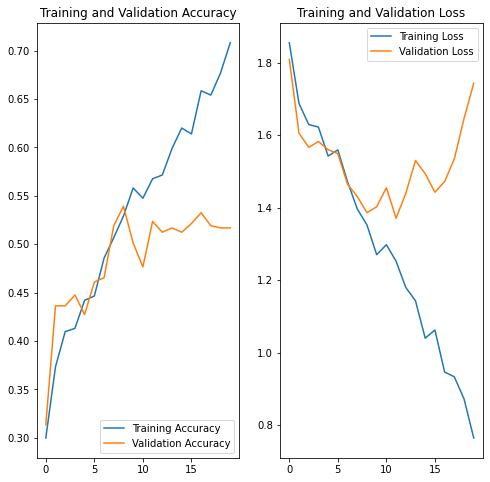

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

#### Results of base model

#### Before answering the question, if the model overfit or underfit, let us understand definition of overfit , underfit and good fit.

* Overfitting - If the training accuracy is high but the validation accuracy is low. Also we need to look at the validation and training loss. If there is a huge deviation between the two, it indicates overfitting.

* Underfitting - The training and validation accuracy will be very similar but very low.

* Good fit - The training and validation accuracy will be very similar and high.

#### Observations:

* <b>The model is overfitting because the training accuracy is around 70% but the validation accuracy is around 51% and also after epoch 7, there is a huge deviation in the loss between validation and training.</b>


In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, 
# choose an appropriate data augumentation strategy. 
# Your code goes here
data_augument = keras.Sequential([
         layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",
                                              input_shape=(img_height,img_width,3)),
         layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
         layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), 
                                        width_factor=(0.2, 0.3), fill_mode='reflect')
])

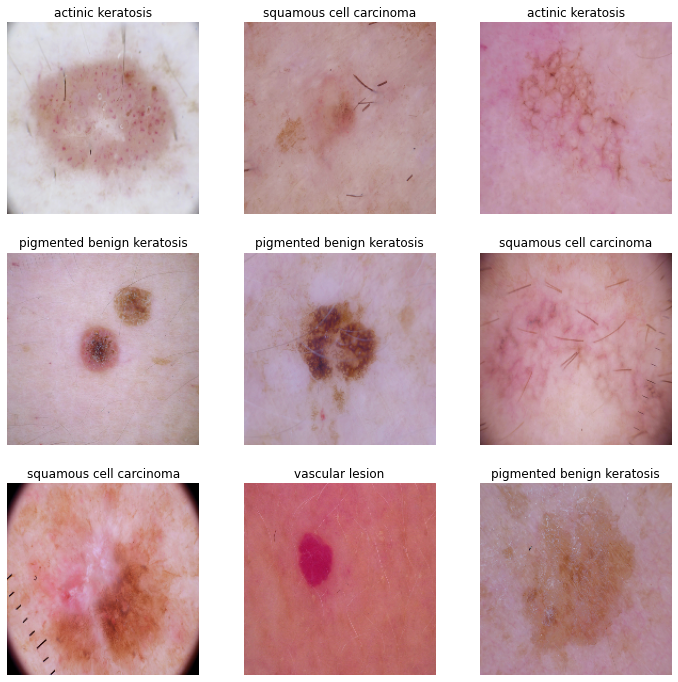

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(len(class_names), activation = "softmax"))


### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 145s 3s/step - loss: 2.0785 - accuracy: 0.1914 - val_loss: 2.0438 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 161s 3s/step - loss: 2.0310 - accuracy: 0.1959 - val_loss: 2.0314 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 167s 3s/step - loss: 2.0379 - accuracy: 0.2081 - val_loss: 2.0219 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 168s 3s/step - loss: 2.0205 - accuracy: 0.1948 - val_loss: 2.0271 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 175s 3s/step - loss: 2.0242 - accuracy: 0.2037 - val_loss: 2.0234 - val_accuracy: 0.2081
Epoch 6/20
56/56 [==============================] - 180s 3s/step - loss: 2.0175 - accuracy: 0.1987 - val_loss: 2.0226 - val_accuracy: 0.2081
Epoch 7/20
56/56 [==============================] - 185s 3s/step - loss: 2.0219 - accuracy: 0.2065 - val_loss: 2.0344 - val_accuracy: 0.1521
Epoch 8/20
56

### Visualizing the results

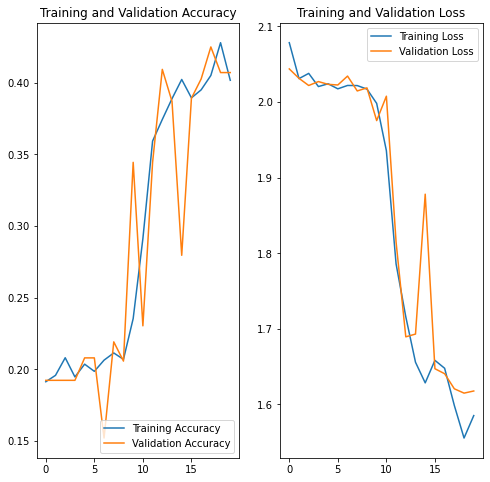

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


 - Observations from Second Model

   * As we can see from the graph the validation and training accuracy and loss is similar and overfitting problem is resolved due to data augmentation.
   * However the training accuracy has dropped from 70% to 40%
   * The number of epochs can be increased to increase the accuracy or we can add more layers or tune the   hyperparameters.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

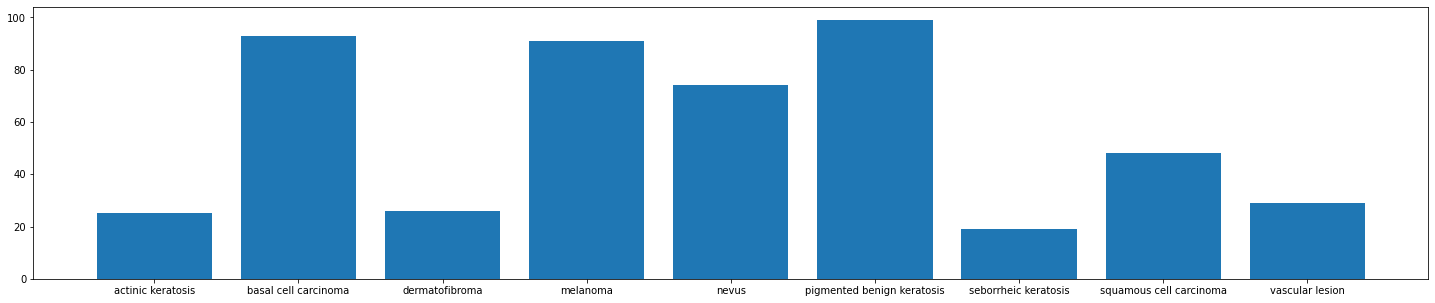

In [ ]:
## Your code goes here.
data = dict()
plt.figure(figsize=(10, 10))
for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(25)
f.set_figheight(5)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
      * Seborrheic keratosis has least number of samples.
      * So also actinic Keratosis, dermatofibroma and vascular lesion also have considerably lesser samples
#### - Which classes dominate the data in terms proportionate number of samples?
      * Pigmented benign keratosis has highest number of samples.
      * melanoma, basal cell carcinoma are almost proporitionately equal and high in number
      * nevus also considers good amount of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset= pathlib.Path("Skin_cancer_Data/Train")
print(path_to_training_dataset)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/Users/kcm/Desktop/Upgrad/MLAI/CNN/Assignment/Skin_cancer_Data/Train/
Initialised with 114 image(s) found.
Output directory set to /Users/kcm/Desktop/Upgrad/MLAI/CNN/Assignment/Skin_cancer_Data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7


Initialised with 376 image(s) found.
Output directory set to /Users/kcm/Desktop/Upgrad/MLAI/CNN/Assignment/Skin_cancer_Data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7


Initialised with 95 image(s) found.
Output directory set to /Users/kcm/Desktop/Upgrad/MLAI/CNN/Assignment/Skin_cancer_Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F923AA226A0>: 100%


Initialised with 438 image(s) found.
Output directory set to /Users/kcm/Desktop/Upgrad/MLAI/CNN/Assignment/Skin_cancer_Data/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x


Initialised with 357 image(s) found.
Output directory set to /Users/kcm/Desktop/Upgrad/MLAI/CNN/Assignment/Skin_cancer_Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F93CC725850>: 100%


Initialised with 462 image(s) found.
Output directory set to /Users/kcm/Desktop/Upgrad/MLAI/CNN/Assignment/Skin_cancer_Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F93D14336D0>: 100%


Initialised with 77 image(s) found.
Output directory set to /Users/kcm/Desktop/Upgrad/MLAI/CNN/Assignment/Skin_cancer_Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F923B730D90>: 100


Initialised with 181 image(s) found.
Output directory set to /Users/kcm/Desktop/Upgrad/MLAI/CNN/Assignment/Skin_cancer_Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F923A7FBFA0>: 100%


Initialised with 139 image(s) found.
Output directory set to /Users/kcm/Desktop/Upgrad/MLAI/CNN/Assignment/Skin_cancer_Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F93D0A551C0>: 100%


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin_cancer_Data/Train/actinic keratosis/ISIC_...,actinic keratosis
1,Skin_cancer_Data/Train/actinic keratosis/ISIC_...,actinic keratosis
2,Skin_cancer_Data/Train/actinic keratosis/ISIC_...,actinic keratosis
3,Skin_cancer_Data/Train/actinic keratosis/ISIC_...,actinic keratosis
4,Skin_cancer_Data/Train/actinic keratosis/ISIC_...,actinic keratosis
...,...,...
2234,Skin_cancer_Data/Train/vascular lesion/ISIC_00...,vascular lesion
2235,Skin_cancer_Data/Train/vascular lesion/ISIC_00...,vascular lesion
2236,Skin_cancer_Data/Train/vascular lesion/ISIC_00...,vascular lesion
2237,Skin_cancer_Data/Train/vascular lesion/ISIC_00...,vascular lesion


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin_cancer_Data/Train/melanoma/output/melanoma_original_ISIC_0001105.jpg_33715aac-ac41-463a-8c35-d87d0c5773fe.jpg',
 'Skin_cancer_Data/Train/melanoma/output/melanoma_original_ISIC_0010036.jpg_c52b1f34-b30d-4557-bff4-1924f990f85d.jpg',
 'Skin_cancer_Data/Train/melanoma/output/melanoma_original_ISIC_0011056.jpg_f500569d-c7f8-4b50-89e8-d99c745dbbe2.jpg',
 'Skin_cancer_Data/Train/melanoma/output/melanoma_original_ISIC_0010468.jpg_bbb1c8d0-3284-4611-8bbc-bf2591d899f5.jpg',
 'Skin_cancer_Data/Train/melanoma/output/melanoma_original_ISIC_0000171.jpg_d9acb125-5351-4c3f-9b2c-e6f1dbe7e38b.jpg',
 'Skin_cancer_Data/Train/melanoma/output/melanoma_original_ISIC_0010938.jpg_3c72823b-0dff-4144-994b-e82b6d7e49c6.jpg',
 'Skin_cancer_Data/Train/melanoma/output/melanoma_original_ISIC_0000400.jpg_97af9b91-d000-493a-b9dc-4ffe0ec6b3d2.jpg',
 'Skin_cancer_Data/Train/melanoma/output/melanoma_original_ISIC_0000151.jpg_a06545d6-c400-45ec-ae40-3364e5bba1d1.jpg',
 'Skin_cancer_Data/Train/melanoma/output/melanom

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label']) 
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train= pathlib.Path("Skin_cancer_Data/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#Add normalization
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#Add normalization
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#Add normalization
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Flatten())
#Add normalization
model.add(BatchNormalization())
model.add(Dense(len(class_names), activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
 # your model fit code

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/Users/kcm/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 549s 3s/step - loss: 4.1948 - accuracy: 0.2943 - val_loss: 5.8053 - val_accuracy: 0.0898
Epoch 2/50
169/169 [==============================] - 642s 4s/step - loss: 3.3072 - accuracy: 0.3155 - val_loss: 5.5769 - val_accuracy: 0.1448
Epoch 3/50
169/169 [==============================] - 674s 4s/step - loss: 3.6060 - accuracy: 0.3422 - val_loss: 4.9733 - val_accuracy: 0.2279
Epoch 4/50
169/169 [==============================] - 689s 4s/step - loss: 3.8498 - accuracy: 0.3578 - val_loss: 4.6980 - val_accuracy: 0.3081
Epoch 5/50
169/169 [==============================] - 712s 4s/step - loss: 3.9229 - accuracy: 0.3494 - val_loss: 9.5177 - val_accuracy: 0.2116
Epoch 6/50
169/169 [==============================] - 651s 4s/step - loss: 3.4002 - accuracy: 0.3884 - val_loss: 6.4020 - val_accuracy: 0.3460
Epoch 7/50
169/169 [==============================] - 671s 4s/step - loss: 2.9194 - accuracy: 0.3809 - val_loss: 9.4606 - val_accuracy: 0.2212
Epoch 8/50

#### **Todo:**  Visualize the model results

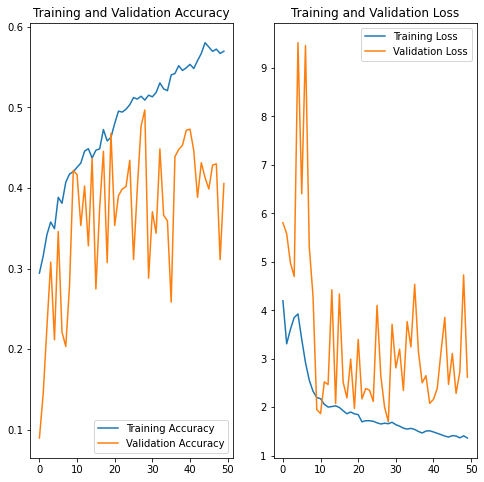

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### Observations from model 3
    * Accuracy on training data has increased by class rebalance using Augmentor library
    * Model is still overfitting
    * Overfitting can be resolved by adding more layers, neurons and dropout layers
    * Accuracy can be further improved by tuning the hyperparameters